In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [195]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

## 1. Global parameters

In [196]:
features_dir = '../data/01_raw/dengue_features_train.csv'
labels_dir = '../data/01_raw/dengue_labels_train.csv'
test_dir = '../data/01_raw/dengue_features_test.csv'
logged = True

test_output_dir = 'output.csv'

corr_threshold = 0.01

## 2. Building blocks functions

In [197]:
def get_dt_col(X , column='week_start_date', format='%Y-%m-%d'):
    """
    Input:
        X
        col = weekofx

    Returns:
        X with X[col].dtype = datetime

    """
    X_new = X.copy()
    X_new[column] = pd.to_datetime(X_new[column], format=format)

    return X_new
    

In [198]:
def get_train_data(features_dir, labels_dir, drop=False, logged=True):
    """ 
    Input:
        str to csv with train features and labels
        drop: to drop NaNs from feature columns.

    Output:
         X, y
    
    """
    features = pd.read_csv(features_dir)
    labels = pd.read_csv(labels_dir)

    data = features.merge(labels)

    print("Preprocessing of training data started.")
    
    if drop:
        data_clean = data.dropna()
        print("Droped {:.2f}% of rows.".format((1 - data_clean.shape[0]/data.shape[0])*100))
    else:
        data_clean = data.copy()

    data_clean.loc[:,'log_total_cases'] = np.log1p(data_clean['total_cases'])
    data_clean_dt = get_dt_col(data_clean)

    
    if logged:
        y = data_clean_dt['log_total_cases']
    else:
        y = data_clean_dt['total_cases']
        
    X = data_clean_dt.drop(columns=['total_cases','log_total_cases'])
    print("Preprocessing of training data finished.\n")
        
    return X, y


In [199]:
def get_train_features(X, y, corr_threshold=0.3, split=False, logged=True):
    """ 
    Input:
        X
        y
        corr_threshold = 0.3
        split: to split the data by cities

    Output:
        numerical_list, categorical_list, other_list
    """
    if logged:
        target_col='log_total_cases'
    else:
        target_col='total_cases'

    data = X.copy()
    data.loc[:,target_col] = y

    print("Feature selection in progress.")
    num_feat = data.select_dtypes(include=[np.number])

    correlation_matrix = num_feat.corr()


    cm = np.abs(correlation_matrix[[target_col]]).sort_values([target_col], ascending = False)

    mask = cm>corr_threshold
    boundary_index = np.sum(mask).iloc[0]

    ordered_num_features = cm.index[1:].to_list()
    numerical_selected = ordered_num_features[0:boundary_index-1]
    
    if split:
        categorical_cols = []
    else:
        categorical_cols = ['city']
        
    other_cols = ['week_start_date']
    
    # Ouput logs
    print("Used {:.2f}% of numerical feature with maximum correlation = {:.4f} and minimum correlation= {:.4f}."
          .format((len(numerical_selected)/num_feat.shape[1])*100, 
          cm[target_col].iloc[1], cm[target_col].iloc[boundary_index-1]))
    print("The categorical features are: {}".format(categorical_cols))
    print("The other selected features are: {}.".format(other_cols))
    print("Feature selection has been accomplished. \n")

    return numerical_selected, categorical_cols, other_cols

In [200]:
def get_trained_pipeline(X, y, columns, model, train_size=0.8, validate = True, shuffle = True):
    """ 
    Input:
        X, y
        corr_threshold: Feature to Y correlation threshold for feature selection.

    Output:
        print statement with val mean abs error
        pipeline
        # X_valid, y_valid (for later validation trials) - commented out for now

    """

    X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=1-train_size, shuffle=shuffle)

    numerical_cols, categorical_cols, other_cols = columns[0], columns[1], columns[2]

    my_cols = categorical_cols + numerical_cols + other_cols

    X_train = X_train_full[my_cols].copy()
    X_valid = X_valid_full[my_cols].copy()

    my_pipeline = get_pipeline(model, columns)
    print("Training in progress.")
    my_pipeline.fit(X_train, y_train)
    print("Training finished.\n")
    
    if validate:
        print("Validation error in progress.")
        preds = my_pipeline.predict(X_valid)
        score = mean_absolute_error(y_valid, preds)
        print(' Finished Validation')
        print('MAE:', score)
        print('\n')

    return my_pipeline

In [221]:
def get_pipeline(model, columns):
    """ 
    Input:
        model
        
    Output:
        pipeline
    """

    numerical_cols, categorical_cols = columns[0], columns[1]

    numerical_transformer = Pipeline( steps =[
        ('imputer', SimpleImputer()),
        ('scalar', StandardScaler()),
        ('minmaxscalar', MinMaxScaler())
    ])
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
    
    return my_pipeline

In [222]:
def get_prediction(X_test, trained_pipeline, exp=False):
    """
    Input:
        X_test
        trained_pipeline

    Output:
        prediction vector

        X_test -> apply dt_col

    """

    X = get_dt_col(X_test)
    prediction = trained_pipeline.predict(X)

    if exp:
        return np.expm1(prediction)
    else:
        return prediction

In [223]:
def get_test_output(X_test, predictions, indexes = ['city', 'year', 'weekofyear'], exponentiate=False, file_dir = '../data/output.csv'):
    """
    Input:
        X_test - 
        predictions - for both cities indexed as X_test requires it and 
                        with the same number of rows as X_test. 
        indexes (List(str)) - By default the columns of X_test for the required format,
                        i.e., ['city', 'year', 'weekofyear'];
        exp (bool) - to exponentiate predictions or not;
                     
        file_dir (str) - directory with the filename of the output csv file;
                         Give an empty string if saving the output is not desired.
        
    Returns:
        output_df (pd.DataFrame) - Dataframe with formatted results
        csv file
    """

    # 1. Exponentiate the predictions if needed.
    if exponentiate:
        result = np.round(np.expm1(predictions)).astype(int)
    else:
        result = np.round(predictions).astype(int)

    # 2. Make the dictionary for the output dataframe format.
    out_dict = {}
    for index in indexes:
        out_dict[index] = X_test[index]

    out_dict['total_cases'] = result
    output_df = pd.DataFrame.from_dict(out_dict).set_index(indexes)
    
    # 3. Save predictions in a csv file ready for submission.
    if file_dir:
        print("Saved predictions in competition file format in path {} . /n".format(file_dir))
        output_df.to_csv(file_dir)
        print('\n')

    return output_df
    

## 3. Pipeline

In [227]:

X, y = get_train_data(features_dir=features_dir, labels_dir=labels_dir, logged=logged)
columns = get_train_features(X=X, y=y, corr_threshold=corr_threshold, logged=logged)

model = RandomForestRegressor(random_state=0)

trained_pipeline = get_trained_pipeline(X=X, y=y, columns=columns, model=model, train_size=0.8, validate = True, shuffle = False)


X_test = pd.read_csv(test_dir)
test_prediction = get_prediction(X_test, trained_pipeline, exp=False)
result_df = get_test_output(X_test=X_test,
                            predictions=test_prediction,
                            exponentiate=True,
                            file_dir=test_output_dir)


Preprocessing of training data started.
Preprocessing of training data finished.

Feature selection in progress.
Used 95.65% of numerical feature with maximum correlation = 0.5640 and minimum correlation= 0.0411.
The categorical features are: ['city']
The other selected features are: ['week_start_date'].
Feature selection has been accomplished. 

Training in progress.


/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Training finished.

Validation error in progress.
 Finished Validation
MAE: 0.9163267942144635


Saved predictions in competition file format in path output.csv . /n




# Timeseries exploration

In [228]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9   reanalysis_air_temp_k                  1446 non-null   float64 

In [229]:
X

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [230]:
data_sj = X[X['city']=='sj']
data_sj.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935],
      dtype='int64', length=936)

In [231]:
data_iq = X[X['city']=='iq']
data_iq.index

Index([ 936,  937,  938,  939,  940,  941,  942,  943,  944,  945,
       ...
       1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455],
      dtype='int64', length=520)

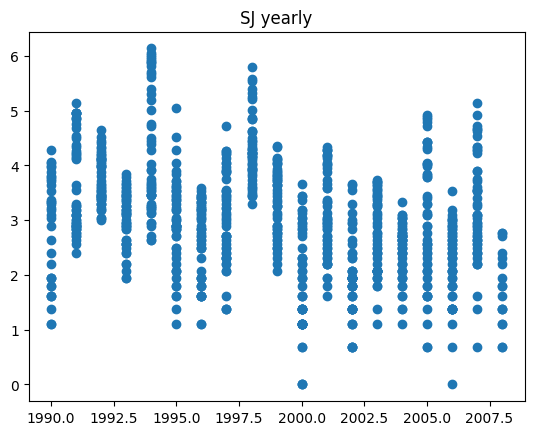

In [232]:
plt.scatter(data_sj['year'],y.iloc[data_sj.index])
plt.title("SJ yearly")
plt.show()

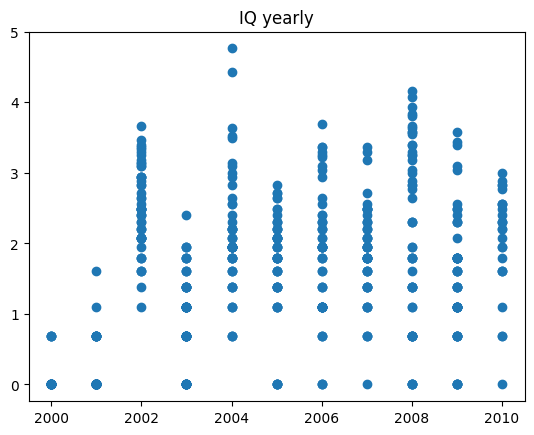

In [233]:
plt.scatter(data_iq['year'],y.iloc[data_iq.index])
plt.title("IQ yearly")
plt.show()

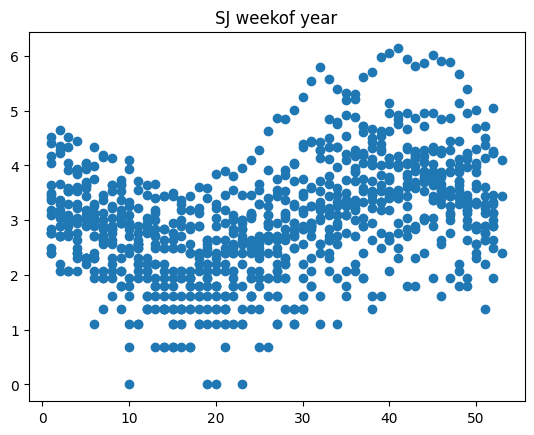

In [234]:
plt.scatter(data_sj['weekofyear'],y.iloc[data_sj.index])
plt.title("SJ weekof year")
plt.show()

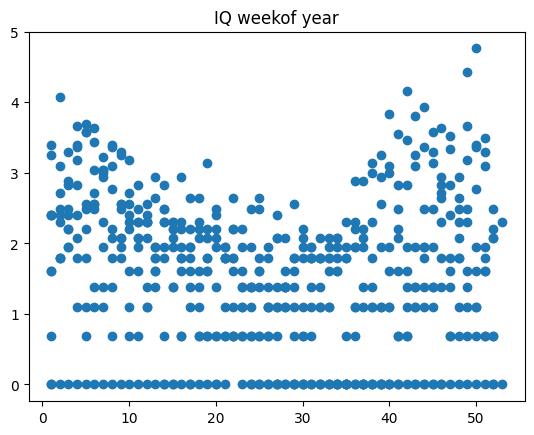

In [235]:
plt.scatter(data_iq['weekofyear'],y.iloc[data_iq.index])
plt.title("IQ weekof year")
plt.show()

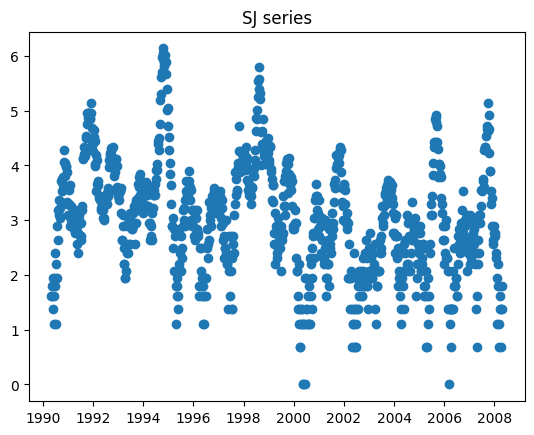

In [236]:
series_sj=data_sj.set_index('week_start_date')
plt.scatter(series_sj.index, y.iloc[data_sj.index])
plt.title("SJ series")
plt.show()

In [237]:
data_iq['week_start_date'].unique()

<DatetimeArray>
['2000-07-01 00:00:00', '2000-07-08 00:00:00', '2000-07-15 00:00:00',
 '2000-07-22 00:00:00', '2000-07-29 00:00:00', '2000-08-05 00:00:00',
 '2000-08-12 00:00:00', '2000-08-19 00:00:00', '2000-08-26 00:00:00',
 '2000-09-02 00:00:00',
 ...
 '2010-04-23 00:00:00', '2010-04-30 00:00:00', '2010-05-07 00:00:00',
 '2010-05-14 00:00:00', '2010-05-21 00:00:00', '2010-05-28 00:00:00',
 '2010-06-04 00:00:00', '2010-06-11 00:00:00', '2010-06-18 00:00:00',
 '2010-06-25 00:00:00']
Length: 520, dtype: datetime64[ns]

In [238]:
series_iq=data_iq.set_index('week_start_date')
series_iq

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4


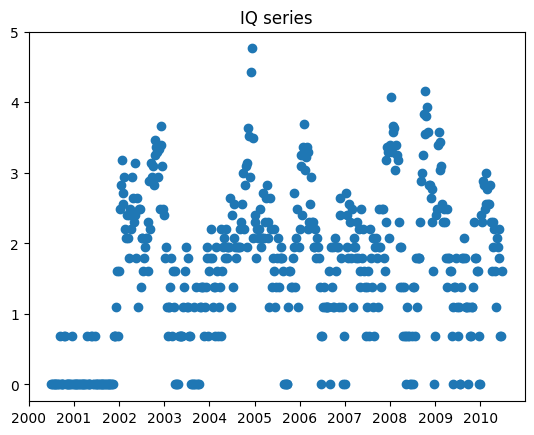

In [239]:
plt.scatter(series_iq.index, y.iloc[data_iq.index])
plt.title("IQ series")
plt.show()

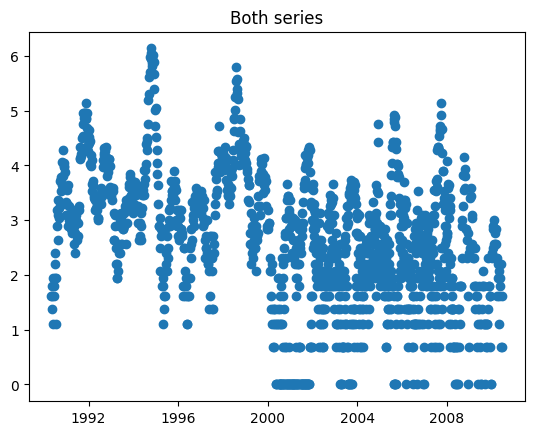

In [240]:
series_both=X.set_index('week_start_date')
plt.scatter(series_both.index, y)
plt.title("Both series")
plt.show()

## Observation:

1. It gets really smudged around 2000, where the iq data starts.

## Action point:
- Do split the data in 2.


936     0.000000
937     0.000000
938     0.000000
939     0.000000
940     0.000000
          ...   
1451    1.791759
1452    2.197225
1453    0.693147
1454    0.693147
1455    1.609438
Name: log_total_cases, Length: 520, dtype: float64

In [241]:
def get_autocorrelation(y, order = 2):
    y_0 = pd.DataFrame(y)

    for i in range(1,order+1):
        y_0.loc[:,i] = y.shift(i)
    
    for i in range(1,order+1):
        plt.scatter(y, y_0.loc[:, i])
        plt.title("Order: {}".format(i))
        plt.show()

    return y_0

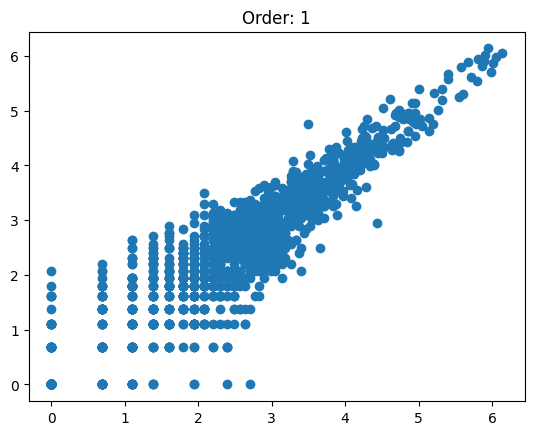

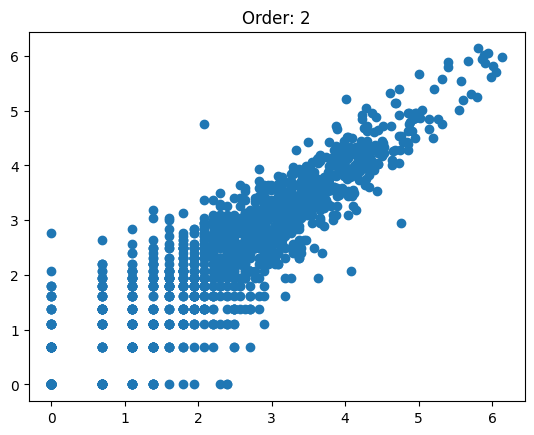

,log_total_cases,1,2
0,1.609438,NaN,NaN
1,1.791759,1.609438,NaN
2,1.609438,1.791759,1.609438
3,1.386294,1.609438,1.791759
4,1.945910,1.386294,1.609438
...,...,...,...
1451,1.791759,1.945910,2.079442
1452,2.197225,1.791759,1.945910
1453,0.693147,2.197225,1.791759
1454,0.693147,0.693147,2.197225


In [242]:
y_corr = get_autocorrelation(y, order=2)
y_corr

## Action point:
Include autocorrelation of order 1 in timeseries.
Use a non-linear trend if any.

In [243]:
test_df = pd.read_csv(test_dir)
X_test = get_dt_col(test_df).set_index('week_start_date')
X_test

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,sj,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,sj,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,sj,2008,20,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,sj,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,iq,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
2013-06-04,iq,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
2013-06-11,iq,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2


In [328]:
test_df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,...,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1


In [244]:
iq_pred_steps = 156
X_test[X_test['city']=='iq']


,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,iq,2010,26,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
2010-07-09,iq,2010,27,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
2010-07-16,iq,2010,28,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
2010-07-23,iq,2010,29,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
2010-07-30,iq,2010,30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,...,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,iq,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
2013-06-04,iq,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,...,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
2013-06-11,iq,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,...,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2


In [245]:
series_iq

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4


In [246]:
sj_pred_steps = 260
X_test[X_test['city']=='sj']

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,sj,2008,18,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,sj,2008,19,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,sj,2008,20,-0.00150,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,sj,2008,22,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,sj,2013,13,-0.08740,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,...,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
2013-04-02,sj,2013,14,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,...,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
2013-04-09,sj,2013,15,-0.11760,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,...,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


In [247]:
series_sj

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,sj,2008,13,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
2008-04-01,sj,2008,14,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
2008-04-08,sj,2008,15,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7


In [248]:
X_test

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,sj,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,sj,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,sj,2008,20,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,sj,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,iq,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
2013-06-04,iq,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
2013-06-11,iq,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2


In [249]:
#!pip install darts

5487.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [269]:
y_iq = y.iloc[data_iq.index]
y_sj = y.iloc[data_sj.index]

train_iq = data_iq[['week_start_date']].copy()
train_iq['y'] = y_iq
#train_iq['t'] =  np.arange(len(train_iq.index))

train_sj = data_sj[['week_start_date']].copy()
train_sj['y'] = y_sj
#train_sj['t'] = np.arange(len(train_sj.index))

In [270]:
train_sj

,week_start_date,y
0,1990-04-30,1.609438
1,1990-05-07,1.791759
2,1990-05-14,1.609438
3,1990-05-21,1.386294
4,1990-05-28,1.945910
...,...,...
931,2008-03-25,1.609438
932,2008-04-01,1.386294
933,2008-04-08,0.693147
934,2008-04-15,1.386294


In [271]:
train_iq

,week_start_date,y
936,2000-07-01,0.000000
937,2000-07-08,0.000000
938,2000-07-15,0.000000
939,2000-07-22,0.000000
940,2000-07-29,0.000000
...,...,...
1451,2010-05-28,1.791759
1452,2010-06-04,2.197225
1453,2010-06-11,0.693147
1454,2010-06-18,0.693147


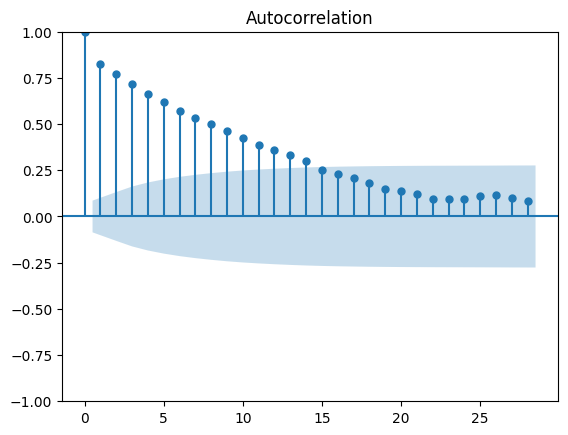

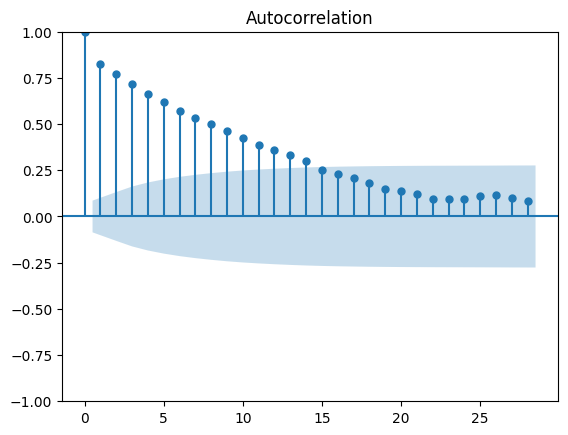

In [261]:
from statsmodels.graphics.tsaplots import plot_acf

# plot the PACF
plot_acf(y_iq)

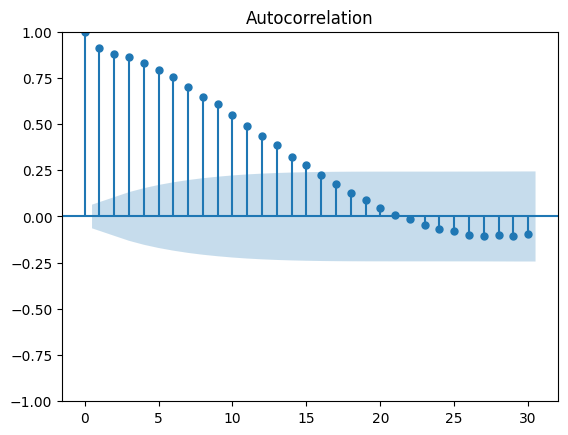

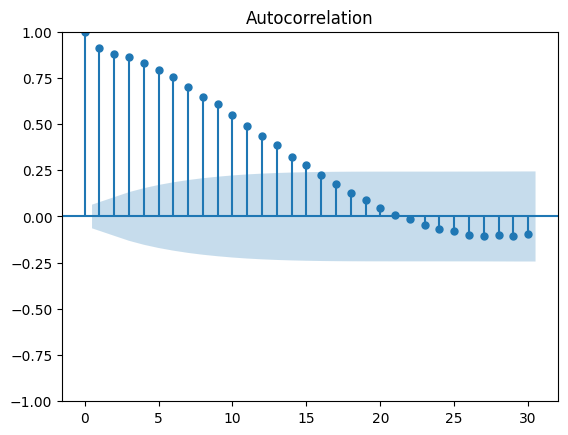

In [262]:
plot_acf(y_sj)

In [317]:
from statsmodels.tsa.api import ExponentialSmoothing

# choose the number of periods
seasonal_periods = 6

# create an instance of exponential smoothing and call its fit() method in one go
holt_winters = ExponentialSmoothing(
    y_sj,
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
#).fit(smoothing_level=0.2, smoothing_trend=0.01, smoothing_seasonal=0.15)
).fit(optimized=True)

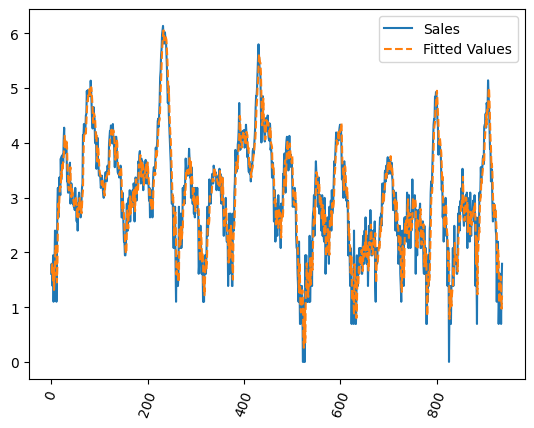

In [318]:
fig, ax = plt.subplots(1, 1)
ax.plot(train_sj.index, train_sj['y'], label='Sales')
ax.plot(train_sj.index, holt_winters.fittedvalues, linestyle='--', label='Fitted Values')
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

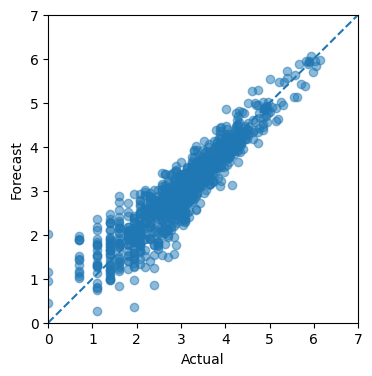

In [319]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train_sj['y'], holt_winters.fittedvalues, alpha=0.5)
ax.plot([0, 7], [0, 7], linestyle='--')
ax.set_xlim([0, 7])
ax.set_xlabel('Actual')
ax.set_ylim([0, 7])
ax.set_ylabel('Forecast')
plt.show()

In [320]:
def mape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()    
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()

    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Avoid division by zero by replacing zeros in the 'actual' array with a small number
    actual = np.where(actual == 0, 1e-10, actual)

    # Calculate MAPE for each data point
    mape_values = np.abs((actual - forecast) / actual)

    # Calculate the mean MAPE value
    mean_mape = np.mean(mape_values) * 100  # Multiply by 100 to get percentage

    return mean_mape

def smape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()
    
    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Calculate SMAPE for each data point
    smape_values = 2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))

    # Calculate the mean SMAPE value
    mean_smape = np.mean(smape_values) * 100  # Multiply by 100 to get percentage

    return mean_smape

In [321]:
# compute MAPE and sMAPE
#mape(np.array(train_sj['y'].to_list()),holt_winters.fittedvalues),
smape(train_sj['y'].to_list(), holt_winters.fittedvalues)

np.float64(13.255561193876101)

In [323]:
sj_pred_steps = 260
sj_values = holt_winters.forecast(sj_pred_steps)

In [324]:
sj_values

936     1.526919
937     1.537958
938     1.619789
939     1.582825
940     1.580936
          ...   
1191    1.554218
1192    1.552329
1193    1.536502
1194    1.497632
1195    1.508671
Length: 260, dtype: float64

In [365]:
sj_df = get_test_output(X_test=test_df.iloc[0:sj_pred_steps], predictions=sj_values.to_list(), indexes = ['city', 'year', 'weekofyear'], exponentiate=True, file_dir = '../data/sj_timeseries_output.csv')


Saved predictions in competition file format in path ../data/sj_timeseries_output.csv . /n




In [358]:
# choose the number of periods
seasonal_periods = 10

# create an instance of exponential smoothing and call its fit() method in one go
holt_winters_iq = ExponentialSmoothing(
    y_iq,
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
#).fit(smoothing_level=0.2, smoothing_trend=0.01, smoothing_seasonal=0.15)
).fit(optimized=True)

/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


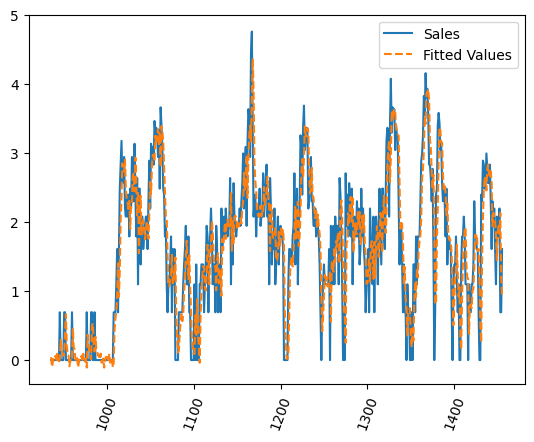

In [359]:
fig, ax = plt.subplots(1, 1)
ax.plot(train_iq.index, train_iq['y'], label='Sales')
ax.plot(train_iq.index, holt_winters_iq.fittedvalues, linestyle='--', label='Fitted Values')
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

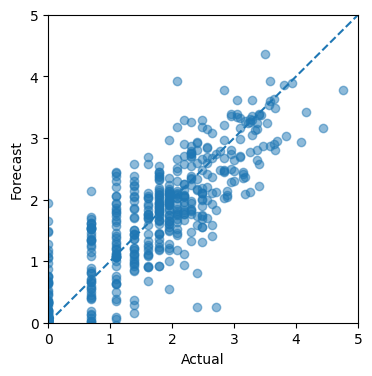

In [360]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train_iq['y'], holt_winters_iq.fittedvalues, alpha=0.5)
ax.plot([0, 5], [0, 5], linestyle='--')
ax.set_xlim([0, 5])
ax.set_xlabel('Actual')
ax.set_ylim([0, 5])
ax.set_ylabel('Forecast')
plt.show()

In [361]:
smape(train_iq['y'].to_list(), holt_winters_iq.fittedvalues)

np.float64(62.00674790818322)

In [362]:
iq_pred_steps = 156
iq_values = holt_winters_iq.forecast(iq_pred_steps)

/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/cristina/miniconda3/envs/dsr-project/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [364]:
iq_df = get_test_output(X_test=test_df.iloc[sj_pred_steps:sj_pred_steps+iq_pred_steps], predictions=iq_values.to_list(), indexes = ['city', 'year', 'weekofyear'], exponentiate=True, file_dir = '../data/iq_timeseries_output.csv')


Saved predictions in competition file format in path ../data/iq_timeseries_output.csv . /n




In [366]:
sj_df

total_cases
city year weekofyear             
sj   2008 18                    4
          19                    4
          20                    4
          21                    4
          22                    4
...                           ...
     2013 13                    4
          14                    4
          15                    4
          16                    3
          17                    4

[260 rows x 1 columns]

In [367]:
iq_df

total_cases
city year weekofyear             
iq   2010 26                    3
          27                    2
          28                    2
          29                    3
          30                    3
...                           ...
     2013 22                    4
          23                    4
          24                    4
          25                    4
          26                    5

[156 rows x 1 columns]

In [372]:
output_df = pd.concat([sj_df,iq_df], axis=0)
output_df

total_cases
city year weekofyear             
sj   2008 18                    4
          19                    4
          20                    4
          21                    4
          22                    4
...                           ...
iq   2013 22                    4
          23                    4
          24                    4
          25                    4
          26                    5

[416 rows x 1 columns]

In [373]:
output_df.to_csv("timeseries_output.csv")

In [375]:
out_1 = pd.read_csv('output.csv')
out_2 = pd.read_csv('timeseries_output.csv')

In [377]:
out_2

,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,4
2,sj,2008,20,4
3,sj,2008,21,4
4,sj,2008,22,4
...,...,...,...,...
411,iq,2013,22,4
412,iq,2013,23,4
413,iq,2013,24,4
414,iq,2013,25,4


In [378]:
score = mean_absolute_error(out_1['total_cases'], out_2['total_cases'])

In [379]:
score

np.float64(11.69951923076923)